In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# File path to the Excel file
file_path = "data.xlsx"  # Replace with your actual file path

# Load the Excel file into a dictionary of DataFrames
# Read all sheets into a dictionary of DataFrames
excel_data = pd.read_excel(os.path.join(os.getcwd(), "data", file_path), sheet_name=None)
print("Excel file successfully loaded!")

# Access specific sheets by name
df_jan_summary = excel_data.get("jan_summary", pd.DataFrame())
df_oct_summary = excel_data.get("oct_summary", pd.DataFrame())

data = pd.concat([df_jan_summary, df_oct_summary], ignore_index=True)


--- Processing Model for Forward_1D_Return_Avg ---
Mean Squared Error for Forward_1D_Return_Avg: 8.5584
R-squared Score for Forward_1D_Return_Avg: 0.0854
Lasso Coefficients:
anonymous signal: -0.0142
Reversal_Frequency: -0.0074
Average_Return: -0.1320
Max_Positive_Return: 0.0995
Max_Negative_Return: 0.0940

--- Processing Model for Forward_2D_Return_Avg ---
Mean Squared Error for Forward_2D_Return_Avg: 25.5665
R-squared Score for Forward_2D_Return_Avg: 0.1373
Lasso Coefficients:
anonymous signal: -0.0273
Reversal_Frequency: -0.0168
Average_Return: -0.2649
Max_Positive_Return: 0.2070
Max_Negative_Return: 0.2025

--- Processing Model for Forward_3D_Return_Avg ---
Mean Squared Error for Forward_3D_Return_Avg: 35.0805
R-squared Score for Forward_3D_Return_Avg: 0.2187
Lasso Coefficients:
anonymous signal: -0.0400
Reversal_Frequency: -0.0217
Average_Return: -0.3096
Max_Positive_Return: 0.2959
Max_Negative_Return: 0.2887

--- Processing Model for Forward_4D_Return_Avg ---
Mean Squared Error 

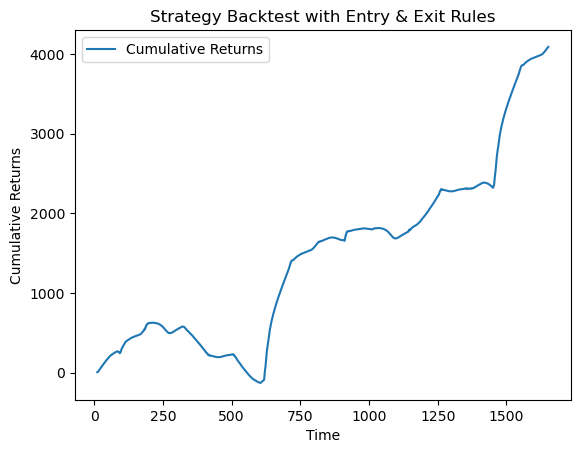

In [8]:
columns_to_use = ['anonymous signal', 'Reversal_Frequency', 'Average_Return', 'Max_Positive_Return',
                  'Max_Negative_Return', 'Forward_1D_Return_Avg', 'Forward_2D_Return_Avg', 
                  'Forward_3D_Return_Avg', 'Forward_4D_Return_Avg', 'Forward_5D_Return_Avg']

data = data[columns_to_use].dropna()  # 删除缺失值

targets = ['Forward_1D_Return_Avg', 'Forward_2D_Return_Avg', 
           'Forward_3D_Return_Avg', 'Forward_4D_Return_Avg','Forward_5D_Return_Avg']

signal_columns = ['anonymous signal', 'Reversal_Frequency', 'Average_Return', 
                  'Max_Positive_Return', 'Max_Negative_Return']

signal_importance = {}

for target in targets:
    print(f"\n--- Processing Model for {target} ---")
    X = data[signal_columns]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
    y_pred = lasso.predict(X_test)

    signal_importance[target] = dict(zip(signal_columns, lasso.coef_))
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error for {target}: {mse:.4f}")
    print(f"R-squared Score for {target}: {r2:.4f}")
    
    print("Lasso Coefficients:")
    for signal, coef in signal_importance[target].items(): print(f"{signal}: {coef:.4f}")
        
print("\n--- Signal Importance Analysis ---")
for target, importance in signal_importance.items():
    print(f"\nTarget: {target}")
    for signal, coef in importance.items():
        print(f"{signal}: {coef:.4f}")

def generate_trading_signals(data, signal_col, threshold):

    data['Signal_Buy'] = np.where(data[signal_col] > threshold, 1, 0)
    data['Signal_Sell'] = np.where(data[signal_col] < -threshold, -1, 0)
    return data

def backtest_strategy(data, target_return_col):
  
    data['Strategy_Return'] = np.where(data['Signal_Buy'] == 1, data[target_return_col], 0)
    
    # 计算累计收益
    data['Cumulative_Returns'] = data['Strategy_Return'].cumsum()

    # 计算命中率（Win Rate）
    total_trades = data['Signal_Buy'].sum() + data['Signal_Sell'].sum()
    profitable_trades = data[data['Strategy_Return'] > 0]['Strategy_Return'].count()
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    
    # 计算最大回撤（Maximum Drawdown）
    peak = data['Cumulative_Returns'].expanding(min_periods=1).max()
    drawdown = (data['Cumulative_Returns'] - peak) / peak
    max_drawdown = drawdown.min()

    return data['Cumulative_Returns'], win_rate, max_drawdown

threshold = 0.5  
data_with_signals = generate_trading_signals(data, 'anonymous signal', threshold)

cumulative_returns, win_rate, max_drawdown = backtest_strategy(data_with_signals, 'Forward_3D_Return_Avg')

print(f"---Hit Ratio (Win Rate): {win_rate:.4f}")
print(f"---Maximum Drawdown: {max_drawdown:.4f}")

plt.plot(cumulative_returns, label='Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Strategy Backtest with Entry & Exit Rules')
plt.legend()
plt.show()